In [26]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.circuit import Parameter
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
import math
import scipy 
from scipy.optimize import minimize
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import networkx as nx
import itertools

In [2]:
# setup simulator using IBM_id
IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm_simulator = Aer.get_backend('qasm_simulator')
stv_simulator = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')


### QLS for Maximum Independent Set

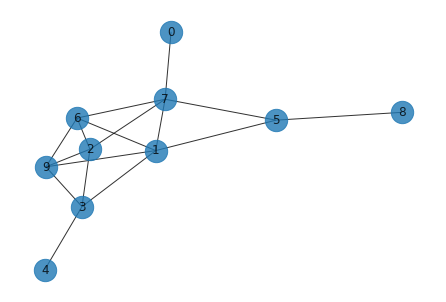

In [3]:
## initiate a random erdos-renyi graph ~
n = 10
p_val = 0.3
seed = 54580324
graph = nx.erdos_renyi_graph(n,p_val, seed= seed)
nx.draw(graph, with_labels= True, alpha= 0.8, node_size= 500)


config = {}
for node in list(graph.nodes) : config[node] = 0
nx.set_node_attributes(graph, config, name= 'val') ## attribute 'val' = 1/0 indicate included/not-included in set 


# plt.figure(figsize= (10,7))
# pos = nx.spring_layout(graph)
# nx.draw_networkx_nodes(graph,pos, node_color= "tab:blue", alpha= 0.8, node_size= 500)
# nx.draw_networkx_edges(graph,pos, width=1.0, alpha=0.5)
# nx.draw_networkx_labels(graph, pos, config)
# plt.show()

In [27]:
## define helper functions ~
def generate_cost_gate_mis(subgraph: nx.Graph, mappings, gamma):
    """ function to genrate cost unitary for the MIS problem
        ARGS:
            subgraph: subgraph for the particular iteration
            gamma: value of paramters gamma
    """
    qreg = QuantumRegister( subgraph.number_of_nodes() , name= 'qreg')
    qc = QuantumCircuit(qreg, name= 'cost ')
    
    for qubit in qreg:
        qc.rz(gamma, qubit)

    return qc
    
def cost_expectation_mis(params_t, betas,  qc: QuantumCircuit , backend= qsm_simulator, shots= 1024 ):
    

    print(qc.parameters) ## set probe
    
    ## create parameter assignment dictionary ~
    params_assignment_dic = dict(list(zip(betas.values(), params_t[:-1])))
    params_assignment_dic[gamma] = params_t[-1]

    print(params_assignment_dic) ## set probe 
    
    ## create copy of circuit for interation ~
    # qc_t = qc.copy()
    qc_t = qc.bind_parameters(params_assignment_dic)    

    print(qc_t.parameters) ## set probe
    
    ## measurements ~
    qc_t.measure_all()
    counts = execute(qc_t, backend= backend, shots= shots).result().get_counts()
    print('counts :' , counts) ## set probe

    ## calculate expectation of cost ~
    cost = 0
    # shots = sum(list(counts.values()))
    for state in list(counts.keys()):
        hamming_weight = state.count(1)
        cost += (counts[state]/shots)*hamming_weight

    print('cost :', cost) ## set probe

    return -1*cost
     
def generate_ansatz_mixers(subgraph: nx.Graph, mixer_action_nodes: set, mappings: dict,  betas  ):
    """ function to generate mixer unitaries for the given 'subgraph' for the MIS problem
        ARGS:
            subgraph: subgraph for the particular iteration
            mixer_action_nodes: set of nodes on which the mixer unitaries will work
            mappings: mapping nodes to qubits
            betas: value of paramters betas
        RETURNS:
            list of mixer unitaries """

    num_qubits = subgraph.number_of_nodes()
    # mappings = dict(zip(subgraph.nodes, range(num_qubits) ))

    qreg = QuantumRegister(num_qubits, name= 'nodes')
    # creg = ClassicalRegister(num_qubits, name= 'creg_nodes')

    mixer_gates = {}
    for node in mixer_action_nodes:
        qc = QuantumCircuit(qreg,  name= 'mixer_'+ str(node))
        neighbors = [ mappings[nbr_node] for nbr_node in subgraph.neighbors(node) ]

        qc.mcrx(betas[node], neighbors, mappings[node] )   
        mixer_gates[node] = qc                        

    return mixer_gates


In [21]:
num_qubits = subgraph.number_of_nodes()
mappings = dict(zip(subgraph.nodes, range(num_qubits) ))

qreg = QuantumRegister(num_qubits, name= 'nodes')
# creg = ClassicalRegister(num_qubits, name= 'creg_nodes')

mixers_gates = {}
for node in mixer_action_nodes:
    qc = QuantumCircuit(qreg,  name= 'mixer_'+ str(node))
    neighbors = [ mappings[nbr_node] for nbr_node in subgraph.neighbors(node) ]

    qc.mcrx(betas[node], neighbors, mappings[node] )   
    mixers_gates[node] = qc                        

n_root, mappings, mixer_action_nodes, mixers_gates

(4,
 {1: 0, 2: 1, 3: 2, 4: 3, 9: 4},
 {3, 4},
 {3: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7ff42b8ea680>,
  4: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7ff451155fc0>})

In [28]:
##init ~
num_repetition = 1

## neighbourhood configs ~
nbrhd_depth = 2

## neighbourhood construction ~
n_root= np.random.choice(graph.nodes)
nbrhd = set(graph.neighbors(n_root))
for depth in range(nbrhd_depth-1):
    # print(depth)
    # print(nbrhd)
    for nbr in nbrhd.copy():
        # print(nbr)
        nbrhd.update(graph.neighbors(nbr) )    
        # print(nbrhd)
subgraph = graph.subgraph(nbrhd)

## initialize neighbourhood circuit ~
num_qubits= subgraph.number_of_nodes()
qc= QuantumCircuit()
for node in subgraph.nodes :
    qc.add_register(QuantumRegister(1, name= 'node: '+str(node)) )
qc.add_register(ClassicalRegister(num_qubits, name= 'creg_nodes') )

## node to qubit mappings ~
mappings = dict(zip(subgraph.nodes, range(num_qubits) ))

## intialize circuit with current values of nodes ~
for node in subgraph.nodes : 
    if subgraph.nodes[node]['val'] == 1: qc.x(mappings[node])

## neighbourhood ansatz ~
mixer_action_nodes = { node for node in subgraph.nodes if list(graph.neighbors(node)) == list(subgraph.neighbors(node))  }
betas = dict([( node, Parameter('beta: '+str(node)) ) for node in mixer_action_nodes])
gamma = Parameter('gamma')

## construct mixers ~
mixer_gates = generate_ansatz_mixers(subgraph, mixer_action_nodes, mappings,  betas)

for repeat in range(num_repetition):
    
    ## copy original circuit ~ 
    qc_t = qc.copy(name= 'qc :'+str(repeat))

    ## construct QLS circuit ~
    partial_mixer_order = list(itertools.permutations(mixer_gates.keys()))[np.random.randint(low=0,high= math.factorial(len(mixer_gates))  )]
    
    for mixer_on_node in partial_mixer_order:
        qc_t.compose( mixer_gates[mixer_on_node].to_gate(), inplace= True)  
    qc_t.barrier()
    cost_unitary = generate_cost_gate_mis(subgraph, mappings, gamma)
    qc_t.compose(cost_unitary, inplace = True)

    ## setup params ~
    betas_t = np.random.uniform(low=0, high= 2*pi, size= len(betas))
    gamma_t = np.random.uniform(low=0, high= 2*pi) 
    params_t = np.append(betas_t, gamma_t)
    
    # params_assignment_dic = dict(list(zip(betas.values(), params_t[:-1])))
    # params_assignment_dic[gamma] = params_t[-1]
    # qc_t = qc_t.assign_parameters(params_assignment_dic)    

    ## paramter optimisation ~
    optimisation = minimize( cost_expectation_mis, params_t, (betas, qc_t), method= 'COBYLA' )
    




ParameterView([Parameter(beta: 5), Parameter(beta: 8), Parameter(gamma)])
{Parameter(beta: 8): 1.296900989120203, Parameter(beta: 5): 3.2797674642545562, Parameter(gamma): 2.2403433184801966}
ParameterView([])


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(beta: 5), Parameter(beta: 8)])]'

In [9]:
qc_t = qc_t.assign_parameters(params_assignment_dic)

NameError: name 'params_assignment_dic' is not defined

In [28]:
qc_t.draw()

┌────────────────────────────┐┌────────────────────────────┐ ░ »
     node: 0: ┤0                           ├┤0                           ├─░─»
              │                            ││                            │ ░ »
     node: 1: ┤1                           ├┤1                           ├─░─»
              │                            ││                            │ ░ »
     node: 2: ┤2                           ├┤2                           ├─░─»
              │  mixer_0(2.54773224285694) ││  mixer_7(5.38999134812801) │ ░ »
     node: 5: ┤3                           ├┤3                           ├─░─»
              │                            ││                            │ ░ »
     node: 6: ┤4                           ├┤4                           ├─░─»
              │                            ││                            │ ░ »
     node: 7: ┤5                           ├┤5                           ├─░─»
              └────────────────────────────┘└────────────────────────────┘ ░ »
creg_nodes: 6/═══════════════════════════════════════════════════════════════»
                                                                             »
«              ┌──────────────────────┐
«     node: 0: ┤ Rz(1.88806134256224) ├
«              ├──────────────────────┤
«     node: 1: ┤ Rz(1.88806134256224) ├
«              ├──────────────────────┤
«     node: 2: ┤ Rz(1.88806134256224) ├
«              ├──────────────────────┤
«     node: 5: ┤ Rz(1.88806134256224) ├
«              ├──────────────────────┤
«     node: 6: ┤ Rz(1.88806134256224) ├
«              ├──────────────────────┤
«     node: 7: ┤ Rz(1.88806134256224) ├
«              └──────────────────────┘
«creg_nodes: 6/════════════════════════
«

In [29]:
partial_mixer_order

(0, 7)

In [30]:
qc_t.parameters, params_assignment_dic

(ParameterView([]),
 {Parameter(beta: 0): 2.547732242856943,
  Parameter(beta: 7): 5.389991348128013,
  Parameter(gamma): 1.8880613425622448})

In [31]:
betas_t, gamma_t, params_t

(array([2.54773224, 5.38999135]),
 1.8880613425622448,
 array([2.54773224, 5.38999135, 1.88806134]))

In [24]:
mixer_gates

{1: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f540706bd00>,
 2: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f540706b550>,
 3: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f540706b4f0>,
 4: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f540708d690>,
 6: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f540708e1a0>,
 9: <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f540708e230>}

In [196]:
dict(list(zip(betas.values(), betas_t)))

{Parameter(beta: 0): 3.888349529406253,
 Parameter(beta: 1): 2.446549762365972,
 Parameter(beta: 2): 6.01393672169364,
 Parameter(beta: 5): 5.331974502734289,
 Parameter(beta: 6): 3.684450639966006,
 Parameter(beta: 7): 2.0226361956587002,
 Parameter(beta: 8): 5.015110025135585,
 Parameter(beta: 9): 0.08394993521912043}

In [185]:
qc_t.assign_parameters({gamma: pi*2}).draw()
# betas[5] = pi
# qc_t.draw()


┌───────────────────┐ ░ ┌────────┐
     node: 1: ┤0                  ├─░─┤ Rz(2π) ├
              │                   │ ░ ├────────┤
     node: 2: ┤1                  ├─░─┤ Rz(2π) ├
              │                   │ ░ ├────────┤
     node: 3: ┤2                  ├─░─┤ Rz(2π) ├
              │                   │ ░ ├────────┤
     node: 4: ┤3                  ├─░─┤ Rz(2π) ├
              │  mixer_6(beta: 6) │ ░ ├────────┤
     node: 5: ┤4                  ├─░─┤ Rz(2π) ├
              │                   │ ░ ├────────┤
     node: 6: ┤5                  ├─░─┤ Rz(2π) ├
              │                   │ ░ ├────────┤
     node: 7: ┤6                  ├─░─┤ Rz(2π) ├
              │                   │ ░ ├────────┤
     node: 9: ┤7                  ├─░─┤ Rz(2π) ├
              └───────────────────┘ ░ └────────┘
creg_nodes: 8/══════════════════════════════════

In [174]:
qc.parameters

ParameterView([Parameter(beta_1), Parameter(beta_2), Parameter(beta_3), Parameter(beta_4), Parameter(beta_6), Parameter(beta_9), Parameter(gamma)])

In [75]:
mixer_gates[7] == mixer_gates[partial_mixer_order[0]]

True

In [103]:
s = '101'
s.count('1')

2

In [140]:
ansatz_set, subgraph.nodes

({0, 1, 2, 6, 7, 9}, NodeView((0, 1, 2, 3, 5, 6, 7, 9)))

In [141]:
n = 3
list(graph.neighbors(n)) == list(subgraph.neighbors(n))

False

In [149]:
qreg1 =QuantumRegister(1)
qreg2 = QuantumRegister(2)

qc = QuantumCircuit(qreg1, qreg2)

In [103]:
nbrhd
graph.nodes[2]['val']

0

In [150]:
qc.add_register(QuantumRegister(2))

In [151]:
qc.draw()

q5: 
      
q6_0: 
      
q6_1: 
      
q7_0: 
      
q7_1:

In [152]:
set = {3,6,1,4}
list(set)

[1, 3, 4, 6]

In [161]:
it = enumerate(set)

In [162]:
l = list(it)
l

[(0, 1), (1, 3), (2, 4), (3, 6)]

In [165]:
l[0][1]

1